In [1]:
import numpy as np
import pandas as pd
traffic=pd.read_excel('04월 서울시 교통량 조사자료.xlsx')
traffic_latlon=pd.read_excel('04월 서울시 교통량 조사자료-수집지점 좌표.xlsx')
charger=pd.read_excel('전기차 충전소 설치현황_20210522.xls')

In [3]:
traffic_latlon.drop(['검지기 유형', '주소', '도로명 주소', '유입 방향'], axis=1, inplace=True)

In [2]:
charger.drop(['시구', '급속충전기(대)', '완속충전기(대)', '지원차종'], axis=1, inplace=True)

In [61]:
null_locs = charger[charger['주소'] == '-'].index
charger.drop(null_locs, axis = 0, inplace = True)

In [75]:
charger['주소'][92]

'서울특별시 강북구 번동 139'

In [8]:
charger.head()

설치장소                        주소
0   LH강남힐스테이트    서울특별시 강남구 자곡동 자곡로3길 21
1      LH서울지사     서울특별시 강남구 선릉로 121길 12
2       가람아파트     서울특별시 강남구 일원동 일원로 127
3  강남구청 공영주차장           서울 강남구 삼성동 16-1
4     강남데시앙파크  서울특별시 강남구 세곡동 헌릉로590길 63

In [17]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm

In [18]:
font_name = fm.FontProperties(fname = 'C:/Windows/Fonts/malgun.ttf').get_name()
matplotlib.rc('font', family = font_name)

In [19]:
seoul_area = gpd.GeoDataFrame.from_file('LARD_ADM_SECT_SGG_11.shp', encoding='cp949')


In [20]:
traffic_latlon['경도'] = traffic_latlon['경도'].astype(float)
traffic_latlon['위도'] = traffic_latlon['위도'].astype(float)
traffic_latlon['geometry'] = traffic_latlon.apply(lambda row : Point([row['경도'], row['위도']]), axis=1)
traffic_latlon = gpd.GeoDataFrame(traffic_latlon, geometry='geometry')
traffic_latlon.crs = {'init':'epsg:4326'}
traffic_latlon = traffic_latlon.to_crs({'init':'epsg:5179'})

C:\Users\yonpo\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [21]:
seoul_area.geometry.area.head()

0    2.453758e+07
1    3.383061e+07
2    3.946631e+07
3    4.685083e+07
4    2.954112e+07
dtype: float64

In [22]:
seoul_area.geometry.length.head()

0    24029.227412
1    30532.219899
2    35504.681042
3    43978.564653
4    27448.698426
dtype: float64

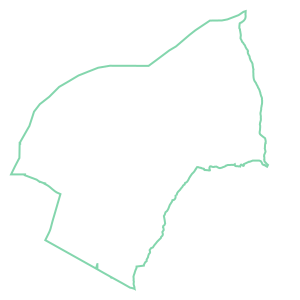

In [24]:
seoul_area.geometry[0].boundary

In [25]:
seoul_area.geometry.centroid.head()

0    POINT (968820.295 1950182.074)
1    POINT (965998.688 1945219.460)
2    POINT (961369.995 1944245.952)
3    POINT (958548.929 1941666.568)
4    POINT (950951.582 1941050.947)
dtype: geometry

In [26]:
print(traffic_latlon['geometry'][0].xy)
print(traffic_latlon['geometry'][0].coords)
print(list(traffic_latlon['geometry'][0].coords))

(array('d', [951291.6503473723]), array('d', [1952278.6480787962]))
[(951291.6503473723, 1952278.6480787962)]


In [27]:
seoul_area.geometry.is_valid.head()

0     True
1    False
2     True
3     True
4     True
dtype: bool

In [28]:
print(traffic_latlon['geometry'][0].within(seoul_area.geometry[0]))

False


In [30]:
distance_score = np.zeros((3019, 5353))

In [32]:
def latlon_calculator(lat, lon):
    ch_lat = int((lat - 126.7341) * 10**4)
    ch_lon = int((lon - 37.4133) * 10**4)
    return ch_lat, ch_lon

In [33]:
import requests
from urllib.parse import urlparse

In [49]:
def euc_distance(loc1, loc2):
    distance = ((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)**(0.5)
    return distance

In [53]:
def min_distance(now_loc, charger_locs):
    distances = []
    for charger_loc in charger_locs:
        distances.append(euc_distance(now_loc, charger_loc))
    return min(distances)

In [67]:
import requests
def getLatLng(address):
    result = ""
 
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
    rest_api_key = 'b1e115113f1c6c2fa72a2d1fe70f70b6'
    header = {'Authorization': 'KakaoAK ' + rest_api_key}
 
    r = requests.get(url, headers=header)
 
    if r.status_code == 200:
        result_address = r.json()["documents"][0]["address"]
        
        result = result_address["y"], result_address["x"]
    else:
        result = "ERROR[" + str(r.status_code) + "]"
    
    return result

address = "서울특별시 강북구 미아동 474"
    
address_latlng = getLatLng(address)
print(address_latlng)

 


('37.6136767350618', '127.025708332062')


In [81]:
charger_locs = []

In [82]:
for i in range(len(charger)):
    try:
        lon, lat = getLatLng(charger['주소'][i])
        ch_lat, ch_lon = latlon_calculator(float(lat), float(lon))
        charger_locs.append((ch_lon, ch_lat))
    except:
        pass

In [83]:
charger_locs

[(584, 3540),
 (1012, 3068),
 (698, 3512),
 (1042, 3133),
 (477, 3674),
 (675, 3582),
 (795, 3122),
 (609, 3684),
 (576, 3756),
 (545, 3707),
 (632, 3775),
 (856, 3128),
 (864, 3158),
 (799, 3450),
 (1034, 3306),
 (889, 3300),
 (871, 3264),
 (748, 3165),
 (809, 3156),
 (878, 3242),
 (1022, 3316),
 (593, 3617),
 (835, 3145),
 (801, 3235),
 (882, 3313),
 (1038, 3298),
 (1030, 3307),
 (1006, 3157),
 (1034, 3105),
 (1014, 3176),
 (1038, 3102),
 (1032, 3124),
 (959, 3197),
 (719, 3485),
 (509, 3664),
 (512, 3685),
 (510, 3700),
 (534, 3588),
 (1050, 3254),
 (962, 3048),
 (1107, 2995),
 (833, 3171),
 (854, 3157),
 (842, 3159),
 (935, 3281),
 (1114, 3221),
 (1108, 3231),
 (1080, 3204),
 (761, 3199),
 (747, 3193),
 (744, 3184),
 (569, 3843),
 (881, 3108),
 (1245, 4141),
 (1159, 3914),
 (1105, 4014),
 (1233, 3990),
 (1494, 4431),
 (1459, 4458),
 (1494, 4458),
 (1522, 4410),
 (1552, 4440),
 (1519, 4442),
 (1178, 4012),
 (1483, 4372),
 (1380, 4406),
 (1458, 4196),
 (1314, 4122),
 (1272, 3908),
 (

In [84]:
for i in range(3019):
    for j in range(5353):
        distance_score[i, j] = min_distance((i, j), charger_locs)

In [85]:
distance_score

array([[1118.64650359, 1117.84122307, 1117.03625725, ..., 1386.001443  ,
        1386.80243726, 1387.60368982],
       [1118.05411318, 1117.24840568, 1116.44301243, ..., 1385.4028295 ,
        1386.20416967, 1387.00576783],
       [1117.46230361, 1116.6561691 , 1115.85034839, ..., 1384.80467937,
        1385.60636546, 1386.40830927],
       ...,
       [1565.46510661, 1564.96453634, 1564.46444511, ..., 1723.77376706,
        1724.30188772, 1724.83042645],
       [1566.33074413, 1565.83045059, 1565.330636  , ..., 1724.62314724,
        1725.15100788, 1725.67928654],
       [1567.1965416 , 1566.69652454, 1566.19698633, ..., 1725.47268886,
        1726.00028969, 1726.52830848]])

In [86]:
np.save('distance_score', distance_score)